# FLOW: Data Description and Transformation (Chemnitz)
## Imports and Settings

In [1]:
%matplotlib inline

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

In [3]:
warnings.filterwarnings('ignore')

In [4]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Helper Functions
Get probability density function (PDF) given list:

In [5]:
def pdf(l):
    counter = collections.Counter(l)
    a = np.column_stack((list(counter.keys()), list(counter.values())))
    a = np.column_stack((a, a[:, 1]/sum(a[:, 1])))
    a = a[a[: ,0].argsort()]
    return a

Get binned probability density function given unbinned probability densities:

In [6]:
def pdf_bin(a, bins):
    decades = np.ceil(np.log10(max(a[:, 0])-min(a[:, 0])))
    bin_min = np.log10(min(a[:, 0]))
    a_bin = np.full((bins, 3), np.nan)
    for i in range(0, bins):
        b = a[(a[:, 0] >= round(10**(bin_min+i*decades/bins))) & (a[:, 0] < round(10**(bin_min+(i+1)*decades/bins)))]
        if len(b)>0:
            a_bin[i, 0] = np.mean(b[:, 0])
            a_bin[i, 1] = sum(b[:, 1])
            a_bin[i, 2] = round(10**(bin_min+(i+1)*decades/bins))-round(10**(bin_min+i*decades/bins))
    a_bin = a_bin[~np.isnan(a_bin[:, 0])]
    a_bin = np.column_stack((a_bin, (a_bin[:, 1]/sum(a[:, 1]))/a_bin[:, 2])) # divide by bin width
    return a_bin

Plot distribution:

In [7]:
def plot_distribution(l, xlabel, ylabel, title, type, binning=True, scaling=True):
    a = pdf(l)
    a_bin = pdf_bin(a, bins=20)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    if type == 'hist':
        if binning == False:
            ax.plot(a[:, 0], a[:, 1], marker='o', markersize=12, ls='', color=color_full[0], label='')
        else:
            ax.plot(a_bin[:, 0], a_bin[:, 1], marker='o', markersize=12, color=color_full[0], ls='', label='')
    if type == 'prob':
        if binning == False:
            ax.plot(a[:, 0], a[:, 2], marker='o', markersize=12, ls='', color=color_full[0], label='')
        else:
            ax.plot(a_bin[:, 0], a_bin[:, 3], marker='o', markersize=12, color=color_full[0], ls='', label='')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if scaling == True:
        ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(title, fontsize=24)
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
    ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.legend(fontsize=18)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.15, top=0.85)

## Data Model
Data generated by users $u$ is modeled as a network with resting points $v$ as nodes and ways $e$ as directed edges. Chains of ways amount to tracks $f$. Tracks originate and terminate at resting points where a user rests for at least 30 minutes ("große Ruhe"). Resting points where users rest for less than 30 minutes ("kleine Ruhe") connect ways into tracks.

## Data Description (Ways)
### Load Data

In [8]:
ways = pd.read_csv('../data/ways_summary.csv', delimiter = ';')

In [9]:
ways.head()

,id,track_id,user_id,stat_group,series,time_begin,time_end,type,start_location,end_location,distance,distance_sum,speed,speed_avg,prev_rp,next_rp,path
0,1,3,2,1,1,2015-11-04 10:12:28,2015-11-04 11:06:35,foot,Stadt Mittweida,Stadt Mittweida,572.94,1145.87,0.64,0.64,50296654,50296655,"LINESTRING(12.97399 50.986117,12.97399 50.9861..."
1,2,3,2,1,1,2015-11-04 11:06:35,2015-11-04 11:06:43,car,Stadt Mittweida,Stadt Mittweida,218.09,1582.05,785.12,392.88,50296655,50296656,"LINESTRING(12.973538 50.987706,12.972125 50.98..."
2,1,15,3,1,1,2015-11-04 12:12:17,2015-11-04 12:16:05,foot,Stadt Mittweida,Stadt Mittweida,358.66,717.31,5.66,5.66,None,50296701,"LINESTRING(12.972569 50.986345,12.972569 50.98..."
3,1,20,3,1,1,2015-11-04 12:56:46,2015-11-04 12:57:59,foot,Stadt Mittweida,Stadt Mittweida,52.57,105.14,2.59,2.59,50296701,50296702,"LINESTRING(12.970304 50.986862,12.970304 50.98..."
4,2,20,3,1,1,2015-11-04 12:57:59,2015-11-04 13:11:34,foot,Stadt Mittweida,Stadt Mittweida,411.81,928.77,1.95,2.27,50296702,50296703,"LINESTRING(12.970304 50.986862,12.970304 50.98..."


### Start Locations

In [10]:
start_location = ways.groupby('start_location').size().sort_values(ascending=False)
start_location.head()

start_location
Stadt Mittweida    14077
Stadt Chemnitz      9341
Stadt Leipzig        655
Lichtenau            256
Stadt Burgstädt      194
dtype: int64

### End Locations

In [11]:
end_location = ways.groupby('end_location').size().sort_values(ascending=False)
end_location.head()

end_location
Stadt Mittweida    13754
Stadt Chemnitz      9737
Stadt Leipzig        592
Lichtenau            227
Stadt Burgstädt      139
dtype: int64

### Modes of Transport

In [12]:
mode = ways.groupby('type').size().sort_values(ascending=False)
mode

type
car      14225
bus       3794
foot      3764
tram      2475
train     1494
dtype: int64

### Timeseries

In [13]:
ways['time_begin_day'] = ways['time_begin'].str[:11]
time_begin_day = ways.groupby('time_begin_day').size().sort_index()
time_begin_day = pd.concat([pd.Series(time_begin_day.index.tolist()), pd.Series(time_begin_day.tolist())], axis=1)
time_begin_day.columns = ['time_begin_day', 'frequency']
time_begin_day['time_begin_day'] = pd.to_datetime(time_begin_day['time_begin_day'])

In [14]:
days_delta = (max(time_begin_day['time_begin_day'])-min(time_begin_day['time_begin_day'])).days
days_list = [min(time_begin_day['time_begin_day'])+datetime.timedelta(days=x) for x in range(0, days_delta+1)]
days_list = pd.DataFrame(days_list, columns=['time_begin_day'])

In [15]:
days = pd.merge(left=time_begin_day, right=days_list, how='right', on='time_begin_day').sort_values('time_begin_day').reset_index(drop=True)

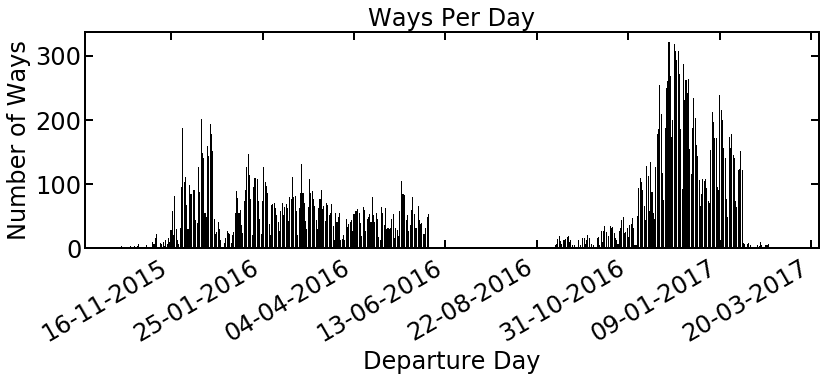

In [16]:
# https://stackoverflow.com/questions/17452179/not-write-out-all-dates-on-an-axis-matplotlib
fig = plt.figure(figsize=(12, 6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=70))
days_dt = [x.to_pydatetime() for x in list(days['time_begin_day'])]
plt.bar(days_dt, days['frequency'], align='center', color=color_full[0])
plt.gcf().autofmt_xdate()
ax = fig.add_subplot(111)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_title('Ways Per Day', fontsize=24)
ax.set_xlabel('Departure Day', fontsize=24)
ax.set_ylabel('Number of Ways', fontsize=24)
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.35, top=0.85)
#plt.savefig('WaysPerDay.pdf')

### Hours

In [17]:
ways['time_begin_hour'] = ways['time_begin'].str[11:13]
time_begin_hour = ways.groupby('time_begin_hour').size().sort_index()
time_begin_hour = pd.concat([pd.Series(time_begin_hour.index.tolist()), pd.Series(time_begin_hour.tolist())], axis=1)
time_begin_hour.columns = ['time_begin_hour', 'frequency']

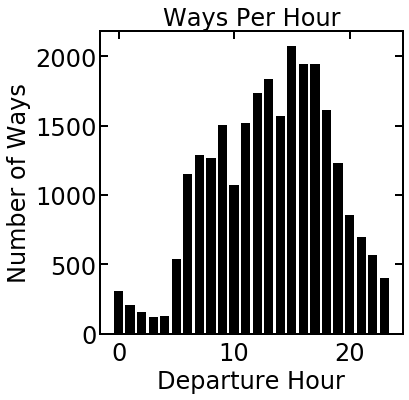

In [18]:
# https://stackoverflow.com/questions/17452179/not-write-out-all-dates-on-an-axis-matplotlib
fig = plt.figure(figsize=(6, 6))
hours = [x for x in range(0, 24)]
plt.bar(hours, time_begin_hour['frequency'], align='center', color=color_full[0])
ax = fig.add_subplot(111)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_title('Ways Per Hour', fontsize=24)
ax.set_xlabel('Departure Hour', fontsize=24)
ax.set_ylabel('Number of Ways', fontsize=24)
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=2, size=2*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.15, top=0.85)
#plt.savefig('WaysPerHour.pdf')

### Number of Ways

In [19]:
e = len(ways)
e

25752

### Number of Tracks

In [20]:
f = len(set(ways['track_id']))
f

14925

### Number of Users

In [21]:
u = len(set(ways['user_id']))
u

164

### Number of Ways Per User

In [22]:
epu = ways.groupby('user_id').size().tolist()

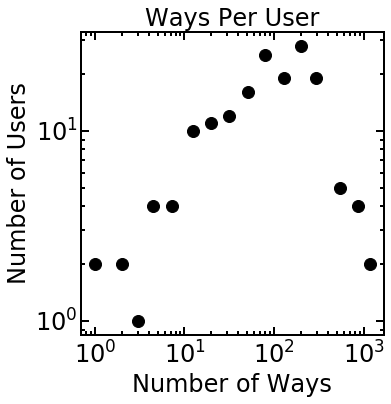

In [23]:
plot_distribution(l=epu, xlabel='Number of Ways', ylabel='Number of Users', title='Ways Per User', type='hist')
#plt.savefig('WaysPerUser.pdf')

### Average Number of Ways Per User

In [24]:
round(e/u, 1)

157.0

### Number of Tracks Per User

In [25]:
ways_ways = ways[['track_id', 'user_id']].drop_duplicates()

In [26]:
fpu = ways_ways.groupby('user_id').size().tolist()

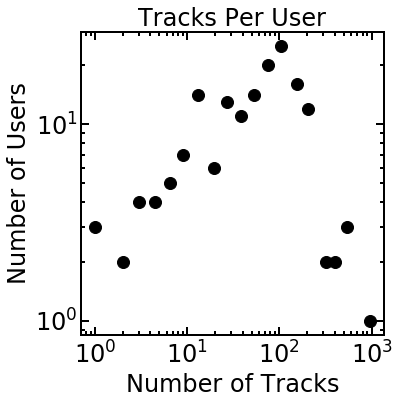

In [27]:
plot_distribution(l=fpu, xlabel='Number of Tracks', ylabel='Number of Users', title='Tracks Per User', type='hist')
#plt.savefig('TracksPerUser.pdf')

### Average Number of Tracks Per User

In [28]:
round(f/u, 1)

91.0

### Number of Ways Per Track

In [29]:
epf = ways.groupby('track_id').size().tolist()

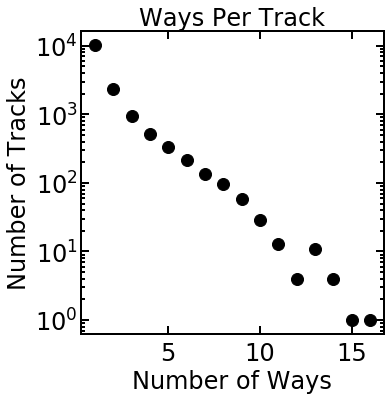

In [30]:
plot_distribution(l=epf, xlabel='Number of Ways', ylabel='Number of Tracks', title='Ways Per Track', type='hist', binning=False, scaling=False)
#plt.savefig('WaysPerTrack.pdf')

### Duration of Ways

### Duration of Tracks

### Duration of Rests

## Data Description (Resting Points)
### Load Data

In [31]:
points = pd.read_csv('../data/particles_resting_2018_v2.txt', delimiter = ';')

In [32]:
points.head()

,id,type,p1_x,p1_y,p2_x,p2_y,time_begin,time_end,user_id,mp_id_p,mp_id_n,location,name,level
0,50296639,small,12.975220,50.986162,12.977208,50.986273,2015-10-09 13:57:43,2015-10-09 13:59:30,2,632049,632050,373,Stadt Mittweida,Gemeinde
1,50296641,small,12.978933,50.982947,12.978970,50.982907,2015-10-12 14:40:46,2015-10-12 14:43:34,2,632051,632052,373,Stadt Mittweida,Gemeinde
2,50296643,small,13.116551,51.120702,13.118111,51.120523,2015-10-22 18:30:41,2015-10-22 18:31:12,2,632053,632054,396,Stadt Döbeln,Gemeinde
3,50296645,small,13.131141,51.114338,13.118115,51.122708,2015-10-22 20:55:40,2015-10-22 21:01:20,2,632055,632056,396,Stadt Döbeln,Gemeinde
4,50296649,small,12.971544,50.985375,12.972673,50.985403,2015-11-02 13:29:47,2015-11-02 13:36:13,2,632059,632060,373,Stadt Mittweida,Gemeinde


### Communities

In [33]:
community = points.groupby('name').size().sort_values(ascending=False)
community.head()

name
Stadt Leipzig      21467
Stadt Mittweida    13627
Stadt Chemnitz     10962
Lichtenau            461
Altmittweida         389
dtype: int64

### Match of Two Coordinates Given Coordinate Resolution
Resting points are always pairs of locations. For example, while waiting for a tram connection, people may walk along the station; at home, people may move (their cell phone) from living room to kitchen. The first point in a pair (p1) is the location where the previous track terminated, the second (p2) is the location where the next track originates. The precision of GPS coordinates is given <a href='https://wiki.openstreetmap.org/wiki/DE:Genauigkeit_von_Koordinaten'>here</a>.

How many pairs match, are identical, at which coordinate resolution?

In [34]:
points['p1_x'] = points['p1_x'].astype('str')
points['p1_y'] = points['p1_y'].astype('str')
points['p2_x'] = points['p2_x'].astype('str')
points['p2_y'] = points['p2_y'].astype('str')

In [35]:
points_small = points[points['type'] == 'small']
points_large = points[points['type'] == 'large']

In [36]:
matches = []
for i in range(0, 9):
    matches.append(sum((points['p1_x'].str[:i+3] == points['p2_x'].str[:i+3]) & (points['p1_y'].str[:i+3] == points['p2_y'].str[:i+3])))
matches_small = []
for i in range(0, 9):
    matches_small.append(sum((points_small['p1_x'].str[:i+3] == points_small['p2_x'].str[:i+3]) & (points_small['p1_y'].str[:i+3] == points_small['p2_y'].str[:i+3])))
matches_large = []
for i in range(0, 9):
    matches_large.append(sum((points_large['p1_x'].str[:i+3] == points_large['p2_x'].str[:i+3]) & (points_large['p1_y'].str[:i+3] == points_large['p2_y'].str[:i+3])))

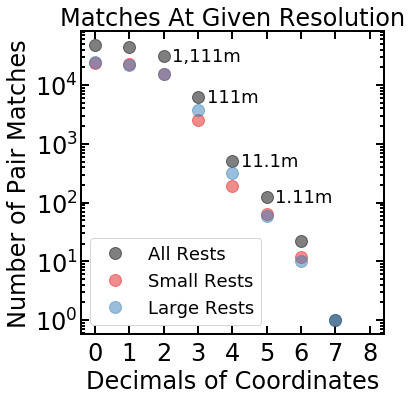

In [37]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.plot(range(0, 9), matches, marker='o', markersize=12, color=color_full[0], ls='', alpha=0.5, label='All Rests')
ax.plot(range(0, 9), matches_small, marker='o', markersize=12, color=color_full[1], ls='', alpha=0.5, label='Small Rests')
ax.plot(range(0, 9), matches_large, marker='o', markersize=12, color=color_full[2], ls='', alpha=0.5, label='Large Rests')
ax.annotate('1.11m', xy=(5+0.25, matches[5]), va='center', fontsize=18)
ax.annotate('11.1m', xy=(4+0.25, matches[4]), va='center', fontsize=18)
ax.annotate('111m', xy=(3+0.25, matches[3]), va='center', fontsize=18)
ax.annotate('1,111m', xy=(2+0.25, matches[2]), va='center', fontsize=18)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_yscale('log')
ax.set_title('Matches At Given Resolution', fontsize=24)
ax.set_xlabel('Decimals of Coordinates', fontsize=24)
ax.set_ylabel('Number of Pair Matches', fontsize=24)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.35, right=0.95, bottom=0.15, top=0.85)
#plt.savefig('MatchesAtGivenResolution.pdf')

### Missing Data

In [38]:
sum(ways['prev_rp'] == 'None')

269

In [39]:
sum(ways['next_rp'] == 'None')

261

## Creation of Network Data
The most simple network is the one that uses the coarse <font face='Courier'>start_location</font> and <font face='Courier'>end_location</font> given in the <font face='Courier'>ways</font> table:

In [40]:
ways_locations = ways[['time_begin', 'time_end', 'start_location', 'end_location', 'type', 'speed']]
ways_locations.rename(columns={'start_location':'location_begin', 'end_location':'location_end'}, inplace=True)

In [41]:
ways_locations.head()

,time_begin,time_end,location_begin,location_end,type,speed
0,2015-11-04 10:12:28,2015-11-04 11:06:35,Stadt Mittweida,Stadt Mittweida,foot,0.64
1,2015-11-04 11:06:35,2015-11-04 11:06:43,Stadt Mittweida,Stadt Mittweida,car,785.12
2,2015-11-04 12:12:17,2015-11-04 12:16:05,Stadt Mittweida,Stadt Mittweida,foot,5.66
3,2015-11-04 12:56:46,2015-11-04 12:57:59,Stadt Mittweida,Stadt Mittweida,foot,2.59
4,2015-11-04 12:57:59,2015-11-04 13:11:34,Stadt Mittweida,Stadt Mittweida,foot,1.95


In [42]:
ways_locations.to_csv('../data/ways_locations.txt', sep='\t', index=False)

Higher resolution is only obtained using GPS coordinates. First, we remove the lines with missing data and merge theways and points tables:

In [43]:
ways = ways[(ways['prev_rp'] != 'None') & (ways['next_rp'] != 'None')]
ways['prev_rp'] = ways['prev_rp'].astype(int)
ways['next_rp'] = ways['next_rp'].astype(int)

In [44]:
ways_coordinates = pd.merge(left=ways, right=points[['id', 'p2_x', 'p2_y']], left_on='prev_rp', right_on='id')
ways_coordinates = pd.merge(left=ways_coordinates, right=points[['id', 'p1_x', 'p1_y']], left_on='next_rp', right_on='id')
ways_coordinates = ways_coordinates[['time_begin', 'time_end', 'p2_x', 'p2_y', 'p1_x', 'p1_y', 'type', 'speed']]
ways_coordinates.rename(columns={'p2_x':'coordinate_begin_x', 'p2_y':'coordinate_begin_y', 'p1_x':'coordinate_end_x', 'p1_y':'coordinate_end_y'}, inplace=True)
ways_coordinates = ways_coordinates[(ways_coordinates['coordinate_begin_x'] != 'nan') & (ways_coordinates['coordinate_begin_y'] != 'nan') & (ways_coordinates['coordinate_end_x'] != 'nan') & (ways_coordinates['coordinate_end_y'] != 'nan')]

In [45]:
ways_coordinates.head()

,time_begin,time_end,coordinate_begin_x,coordinate_begin_y,coordinate_end_x,coordinate_end_y,type,speed
0,2015-11-04 10:12:28,2015-11-04 11:06:35,12.9735145569,50.9858551025,12.973315239,50.9876289368,foot,0.64
1,2015-11-04 11:06:35,2015-11-04 11:06:43,12.9731607437,50.9865379333,12.9733314514,50.9862861633,car,785.12
2,2015-11-04 12:56:46,2015-11-04 12:57:59,12.9704751,50.9869392,12.9712393,50.9868844,foot,2.59
3,2015-11-04 12:57:59,2015-11-04 13:11:34,12.9727888,50.9864179,12.9706122,50.9855912,foot,1.95
4,2015-11-04 13:11:34,2015-11-04 13:14:24,12.9704209,50.9863855,12.97028893,50.98622314,car,22.64


Then, we create nodelists and edgelists for variable resolutions of GPS coordinates:

In [46]:
nodes = []
for i in range(0, 9):
    # create nodelists
    ways_coordinates_dec = ways_coordinates.copy()
    ways_coordinates_dec['coordinate_begin_x'] = ways_coordinates_dec['coordinate_begin_x'].str[:i+3]
    ways_coordinates_dec['coordinate_begin_y'] = ways_coordinates_dec['coordinate_begin_y'].str[:i+3]
    ways_coordinates_dec['coordinate_end_x'] = ways_coordinates_dec['coordinate_end_x'].str[:i+3]
    ways_coordinates_dec['coordinate_end_y'] = ways_coordinates_dec['coordinate_end_y'].str[:i+3]
    ways_coordinates_begin_dec = ways_coordinates_dec[['coordinate_begin_x', 'coordinate_begin_y']].rename(columns={'coordinate_begin_x':'coordinate_x', 'coordinate_begin_y':'coordinate_y'})
    ways_coordinates_end_dec = ways_coordinates_dec[['coordinate_end_x', 'coordinate_end_y']].rename(columns={'coordinate_end_x':'coordinate_x', 'coordinate_end_y':'coordinate_y'})
    points_coordinates_dec = pd.concat([ways_coordinates_begin_dec, ways_coordinates_end_dec]).drop_duplicates().reset_index(drop=True)
    points_coordinates_dec['id'] = points_coordinates_dec.index
    points_coordinates_dec = points_coordinates_dec[['id', 'coordinate_x', 'coordinate_y']]
    points_coordinates_dec.to_csv('../data/points_coordinates_dec' + str(i) + '.txt', sep='\t', index=False)
    # store number of distinct nodes
    nodes.append(len(points_coordinates_dec))
    # create edgelists
    ways_coordinates_dec = pd.merge(left=ways_coordinates_dec, right=points_coordinates_dec, left_on=['coordinate_begin_x', 'coordinate_begin_y'], right_on=['coordinate_x', 'coordinate_y'])
    ways_coordinates_dec = ways_coordinates_dec.rename(columns={'id':'coordinate_id_begin'})
    ways_coordinates_dec = pd.merge(left=ways_coordinates_dec, right=points_coordinates_dec, left_on=['coordinate_end_x', 'coordinate_end_y'], right_on=['coordinate_x', 'coordinate_y'])
    ways_coordinates_dec = ways_coordinates_dec.rename(columns={'id':'coordinate_id_end'})
    ways_coordinates_dec = ways_coordinates_dec[['time_begin', 'time_end', 'coordinate_id_begin', 'coordinate_id_end', 'type', 'speed']]
    ways_coordinates_dec.to_csv('../data/ways_coordinates_dec' + str(i) + '.txt', sep='\t', index=False)

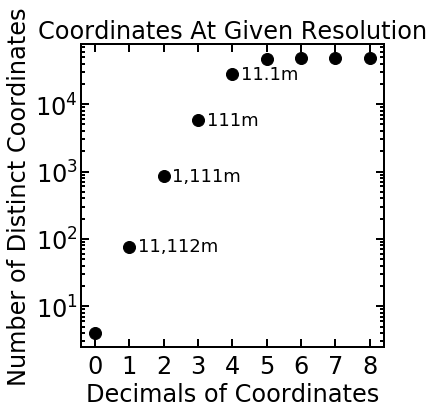

In [47]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.plot(range(0, 9), nodes, marker='o', markersize=12, color=color_full[0], ls='')
ax.annotate('11.1m', xy=(4+0.25, nodes[4]), va='center', fontsize=18)
ax.annotate('111m', xy=(3+0.25, nodes[3]), va='center', fontsize=18)
ax.annotate('1,111m', xy=(2+0.25, nodes[2]), va='center', fontsize=18)
ax.annotate('11,112m', xy=(1+0.25, nodes[1]), va='center', fontsize=18)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_yscale('log')
ax.set_title('Coordinates At Given Resolution', fontsize=24)
ax.set_xlabel('Decimals of Coordinates', fontsize=24)
ax.set_ylabel('Number of Distinct Coordinates', fontsize=24)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.tick_params(axis="x", which='major', direction="in", width=2, size=4*2, labelsize=24, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=2, size=4*2, labelsize=24)
ax.tick_params(axis="y", which='minor', direction="in", width=2, size=2*2, labelsize=24)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.legend(fontsize=18)
plt.subplots_adjust(left=0.35, right=0.95, bottom=0.15, top=0.85)
#plt.savefig('CoordinatesAtGivenResolution.pdf')